# Imports

In [2]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Constants

In [4]:
input_width = 150
input_height = 150

train_epochs = 20
learning_rate = 0.001

train_batch_size = 14
validation_batch_size = 16

train_steps = 6
validation_steps = 1

checkpoint_path = "checkpoints/feature_extraction/cp-{epoch:04d}.ckpt"
checkpoint_frequency = 1

train_dir = 'train3'
validation_dir = 'val3'

train_0_dir = os.path.join(train_dir, '0')
train_1_dir = os.path.join(train_dir, '1')

validation_0_dir = os.path.join(validation_dir, '0')
validation_1_dir = os.path.join(validation_dir, '1')

# Feature Extraction Using a Pretrained Model

Extract intermediate representations from the [Inception V3 model](https://arxiv.org/abs/1512.00567), which has been pre-trained on [ImageNet](http://image-net.org/). Use these extracted representations to train a new classifier for classifying images.

### Instantiate an Inception V3 Model

Load weights for the Inception V3 model that was trained on ImageNet. Set `include_top=False` so that the classification layers of the model are not included. Make the model non-trainable since it will only be used for feature extraction.

In [60]:
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape=(input_width, input_height, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

### Create a New Classifier

Use the `mixed7` layer from the Inception V3 model for feature extraction. This will give a 7x7 feature map. Then stick a fully connected classifier on top of `last_input`. This classifier will be trained to classify images by using the 7x7 feature map extracted from the Inception V3 model.

In [61]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Create model
model = Model(pre_trained_model.input, x)

# Print architecture of model
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 74, 74, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 74, 74, 32)   96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 74, 74, 32)   0           batch_normalization_470[0][0]    
____________________________________________________________________________________________

### Training Configuration

Train model with the `binary_crossentropy` loss function, use the `rmsprop` optimizer, and monitor accuracy, recall, and precision during training. Configure checkpoints to save weights of the model. 

In [62]:
# Configure training specifications
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=learning_rate), metrics=[
    'acc', 
    Recall(name='recall'),
    Precision(name='precision')])

# Configure checkpoints
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=checkpoint_frequency)

# Data Preprocessing

Create data generators to read pictures and feed them to the network. Resize all images to be `150x150` pixels. Normalize data by making pixel values in range `[0, 1]` instead of `[0, 225]`. Augment training images by applying the following random transformations:
- `rotation_range` is for randomly rotating the image.
- `width_shift` and `height_shift` are for randomly translating pictures vertically or horizontally.
- `shear_range` is for randomly applying shearing transformations.
- `zoom_range` is for randomly zooming inside pictures.
- `horizontal_flip` is for randomly flipping half of the images horizontally.
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [63]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(input_width, input_height),
        batch_size=train_batch_size,
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(input_width, input_height),
        batch_size=validation_batch_size,
        class_mode='binary')

Found 84 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# Training

In [64]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_steps,  # training images = batch_size * steps
      epochs=train_epochs,
      callbacks=[cp_callback],
      validation_data=validation_generator,
      validation_steps=validation_steps,  # validation images = batch_size * steps
      verbose=2)

Epoch 1/20

Epoch 00001: saving model to checkpoints/feature_extraction/cp-0001.ckpt
6/6 - 15s - loss: 4.6652 - acc: 0.5595 - recall: 0.5476 - precision: 0.5610 - val_loss: 9.2944 - val_acc: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000
Epoch 2/20

Epoch 00002: saving model to checkpoints/feature_extraction/cp-0002.ckpt
6/6 - 6s - loss: 2.8394 - acc: 0.5238 - recall: 0.6429 - precision: 0.5192 - val_loss: 3.4325 - val_acc: 0.5000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/20

Epoch 00003: saving model to checkpoints/feature_extraction/cp-0003.ckpt
6/6 - 5s - loss: 1.4556 - acc: 0.6548 - recall: 0.6190 - precision: 0.6667 - val_loss: 1.2198 - val_acc: 0.6250 - val_recall: 1.0000 - val_precision: 0.5714
Epoch 4/20

Epoch 00004: saving model to checkpoints/feature_extraction/cp-0004.ckpt
6/6 - 5s - loss: 1.0268 - acc: 0.6905 - recall: 0.7143 - precision: 0.6818 - val_loss: 0.8482 - val_acc: 0.7500 - val_recall: 0.6250 - val_precision: 0.8333
Epoch 5/20

Epoch 00005

# Plot Metrics

Plot the training/validation loss, accuracy, recall, and precision collected during training.

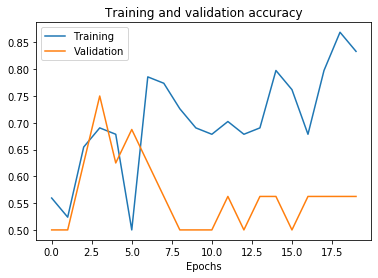

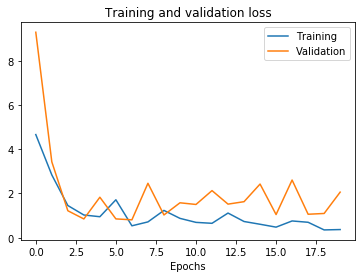

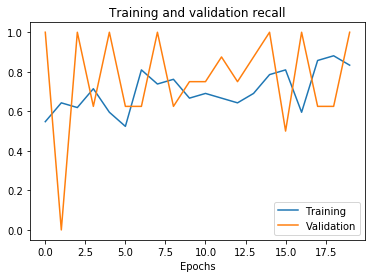

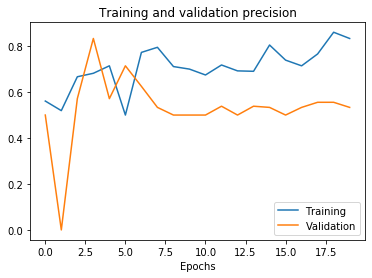

In [65]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of loss results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Retrieve a list of recall results on training and validation data
# sets for each training epoch
recall = history.history['recall']
val_recall = history.history['val_recall']

# Retrieve a list of loss precision on training and validation data
# sets for each training epoch
precision = history.history['precision']
val_precision = history.history['val_precision']

# Get number of epochs
epochs = range(len(acc))

%matplotlib inline

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

# Plot training and validation recall per epoch
plt.plot(epochs, recall, label='Training')
plt.plot(epochs, val_recall, label='Validation')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

# Plot training and validation precision per epoch
plt.plot(epochs, precision, label='Training')
plt.plot(epochs, val_precision, label='Validation')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.legend()

# Load Checkpoint

Select a checkpoint from training to use to classify images.

In [69]:
load_checkpoint = 'checkpoints/feature_extraction/cp-0004.ckpt'
model.load_weights(load_checkpoint)

# View Predictions

Show test images along with the model's prediction compared to the expected value.

In [5]:
predict_datagen = ImageDataGenerator(rescale=1./255)
image_data = predict_datagen.flow_from_directory(
        validation_dir,
        target_size=(input_width, input_height))

for image_batch, label_batch in image_data:
    break
print(image_batch)
result_batch = model.predict(image_batch)

plt.figure(figsize=(18,20))
plt.subplots_adjust(hspace=0.1)
correct = 0
for n in range(len(image_batch)):
    plt.subplot(4,4,n+1)
    plt.imshow(image_batch[n])
    label = 0
    if label_batch[n][1] == 1:
        label = 1
    color = 'r'
    if label == round(result_batch[n][0]):
        color = 'g'
        correct += 1
    title = 'Predicted: ' + str(result_batch[n][0]) + '\nActual: ' + str(label)
    title_obj = plt.title(title)
    plt.setp(title_obj, color=color)
    plt.axis('off')

print('Accuracy =', correct/len(image_batch))

Found 16 images belonging to 2 classes.
[[[[0.25490198 0.20392159 0.06666667]
   [0.38431376 0.34509805 0.14509805]
   [0.3372549  0.28235295 0.12941177]
   ...
   [0.6117647  0.64705884 0.6745098 ]
   [0.6039216  0.6392157  0.6666667 ]
   [0.6039216  0.6392157  0.6745098 ]]

  [[0.34117648 0.2901961  0.1254902 ]
   [0.3254902  0.2627451  0.13333334]
   [0.38823533 0.3372549  0.16470589]
   ...
   [0.60784316 0.6431373  0.67058825]
   [0.6117647  0.64705884 0.6745098 ]
   [0.6        0.63529414 0.6627451 ]]

  [[0.427451   0.37254903 0.21960786]
   [0.2901961  0.23529413 0.13333334]
   [0.36862746 0.34117648 0.1254902 ]
   ...
   [0.59607846 0.6313726  0.65882355]
   [0.6        0.63529414 0.6627451 ]
   [0.5921569  0.627451   0.654902  ]]

  ...

  [[0.3137255  0.32941177 0.34117648]
   [0.31764707 0.32941177 0.34901962]
   [0.3019608  0.3137255  0.33333334]
   ...
   [0.5137255  0.5137255  0.37254903]
   [0.5019608  0.5137255  0.34509805]
   [0.54509807 0.5294118  0.38431376]]

  [[0

NameError: name 'model' is not defined